# CyNetDiff Demo

This notebook is meant as a demonstration of the capabilities of the CyNetDiff library for simulating network diffusion. We will go through some typical use cases that highlight how CyNetDiff enables the processing of larger graphs.


In [16]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from cynetdiff.utils import networkx_to_ic_model, set_activation_random_sample

import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mod_config
import numpy as np
from coloraide import Color
import heapq
from tqdm.notebook import trange, tqdm
import time

from benchmarks import compute_marginal_gain

Graph = nx.Graph | nx.DiGraph

# Simulating Diffusion

As a first example, we wish to


In [2]:
def create_plot_for_nodes_infected_perc(
    graphs: Graph | list[Graph],
    plot_iqr: bool = False,
):
    """
    Create a plot of the percentage of nodes infected for a CyNetDiff model across multiple trials for up to four graphs.
    If plot_iqr is True, plots the interquartile range and horizontal lines.
    """

    if not isinstance(graphs, list):
        graphs = [graphs]

    # Generate distinct colors for each graph using Coloraide
    colors = [Color.random("srgb") for _ in graphs]

    # Generate distinct lighter-colors for each graph for IQR plotting
    light_colors = []
    for color_str in colors:
        color = Color(color_str, "srgb")
        color[3] = 0.5
        light_colors.append(color)

    max_length = 0
    all_graphs_data = []

    # Get all the data for graphs
    for graph in graphs:
        model = networkx_to_ic_model(graph)
        seeds = set(random.sample(list(graph.nodes()), 100))
        model.set_seeds(seeds)
        num_trials = 100

        all_trials_infected_nodes = []

        for _ in range(num_trials):
            model.reset_model()

            infected_nodes_over_time = []
            previous_activated = -1
            current_activated = 0

            while previous_activated != current_activated:
                previous_activated = current_activated
                model.advance_model()
                current_activated = model.get_num_activated_nodes()
                number_infected = current_activated
                infected_nodes_over_time.append(number_infected)

            all_trials_infected_nodes.append(infected_nodes_over_time)
            max_length = max(max_length, len(infected_nodes_over_time))

        all_graphs_data.append(all_trials_infected_nodes)

    # Pad all data
    padded_all_graphs_data = []
    for graph_data in all_graphs_data:
        padded_trials = [
            trial + [trial[-1]] * (max_length - len(trial)) for trial in graph_data
        ]
        padded_all_graphs_data.append(padded_trials)

    # Graph Data
    for idx, graph_data in enumerate(padded_all_graphs_data):
        median_infected = np.median(graph_data, axis=0)

        if plot_iqr:
            iqr_values = [
                np.percentile(
                    [trial[i] if i < len(trial) else trial[-1] for trial in graph_data],
                    [25, 75],
                )
                for i in range(max_length)
            ]
            lower_quartile, upper_quartile = zip(*iqr_values)

            for y in median_infected:
                plt.axhline(y=y, color=colors[idx], linestyle="--", alpha=0.2)

            plt.fill_between(
                range(max_length),
                lower_quartile,
                upper_quartile,
                color=light_colors[idx],
                alpha=0.3,
            )

        plt.plot(
            median_infected, label=f"Graph {idx+1} Median Infected", color=colors[idx]
        )

    plt.xlabel("Iteration")
    plt.ylabel("Number of Infected Nodes")
    plt.title("Diffusion Process Over Time")
    plt.legend()
    plt.show()

In [3]:
def create_plot_for_delta_nodes_infected(
    graph1: nx.Graph,
    graph2: nx.Graph = None,
    graph3: nx.Graph = None,
    graph4: nx.Graph = None,
    plot_iqr: bool = False,
):
    """
    Create a plot of the delta of nodes infected for a CyNetDiff model across multiple trials for up to four graphs.
    If plot_iqr is True, plots the interquartile range and horizontal lines.
    """
    graphs = [g for g in [graph1, graph2, graph3, graph4] if g is not None]
    for graph in graphs:
        model = networkx_to_ic_model(graph)
        seeds = set(random.sample(list(graph.nodes()), 100))
        model.set_seeds(seeds)
        num_trials = 1

        all_trials_delta_nodes = []
        max_length = 0

        for _ in range(num_trials):
            model.reset_model()

            delta_nodes_over_time = []
            previous_activated = -1
            current_activated = 0

            while previous_activated != current_activated:
                previous_activated = current_activated
                model.advance_model()
                current_activated = model.get_num_activated_nodes()
                delta_nodes_over_time.append(current_activated - previous_activated)

            max_length = max(max_length, len(delta_nodes_over_time))
            all_trials_delta_nodes.append(delta_nodes_over_time)

        padded_trials = [
            trial + [0] * (max_length - len(trial)) for trial in all_trials_delta_nodes
        ]

        median_delta = np.median(padded_trials, axis=0)

        if plot_iqr:
            iqr_values = [
                np.percentile(
                    [trial[i] if i < len(trial) else 0 for trial in padded_trials],
                    [25, 75],
                )
                for i in range(max_length)
            ]
            lower_quartile, upper_quartile = zip(*iqr_values)

            for y in median_delta:
                plt.axhline(y=y, color="gray", linestyle="--", alpha=0.2)

            plt.fill_between(
                range(len(lower_quartile)),
                lower_quartile,
                upper_quartile,
                color="#7daec7",
                alpha=0.3,
            )

        plt.plot(median_delta, label="Median Delta Nodes", color="#3f83a6")

    plt.xlabel("Iteration")
    plt.ylabel("Delta Nodes Infected")
    plt.title("Diffusion Process Over Time")
    plt.legend()
    plt.show()

In [4]:
# O = nx.fast_gnp_random_graph(15000, 2)
graphs = []

base_graph = nx.watts_strogatz_graph(15_000, 10, 0.01)


graphs = [
    nx.watts_strogatz_graph(15_000, 10, 0.01),
    nx.watts_strogatz_graph(15_000, 10, 0.02),
    nx.watts_strogatz_graph(15_000, 10, 0.05),
    nx.watts_strogatz_graph(15_000, 10, 0.10),
    nx.watts_strogatz_graph(15_000, 10, 0.20),
]
graph = nx.watts_strogatz_graph(15_000, 10, 0.01)
# B = nx.erdos_renyi_graph(100, 0.1)
# nx.set_edge_attributes(G, 0.01, "activation_prob")
# nx.set_edge_attributes(O, 0.01, "activation_prob")
# nx.set_edge_attributes(B, 0.01, "activation_prob")

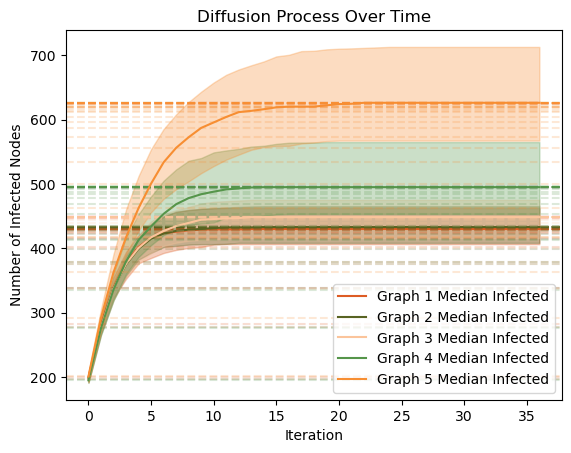

In [5]:
create_plot_for_nodes_infected_perc(graphs, True)

In [17]:
def celf(
    graph: Graph, k: int, method: str, mc: int = 1_000
) -> tuple[set[int], list[float]]:
    """
    Input: graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    Code adapted from this blog post:
    https://hautahi.com/im_greedycelf
    """

    # Make cynetdiff model
    cynetdiff_model = networkx_to_ic_model(graph)

    # NDLib Model
    ndlib_model = ep.IndependentCascadesModel(graph)

    config = mod_config.Configuration()

    # Assume that thresholds were already set.
    for u, v, data in graph.edges(data=True):
        config.add_edge_configuration("threshold", (u, v), data["activation_prob"])

    # Don't randomly infect anyone to start, just use given seeds.
    config.add_model_parameter("fraction_infected", 0.0)
    ndlib_model.set_initial_status(config)

    # Prepare graph
    dir_graph = graph
    if not dir_graph.is_directed():
        dir_graph = dir_graph.to_directed()

    # Run the CELF algorithm
    marg_gain = []

    # First, compute all marginal gains
    print("Computing initial marginal gains.")
    for node in tqdm(list(dir_graph.nodes())):
        marg_gain.append(
            (
                -compute_marginal_gain(
                    cynetdiff_model, ndlib_model, dir_graph, node, set(), mc, method
                ),
                node,
            )
        )

    heapq.heapify(marg_gain)

    max_mg, selected_node = heapq.heappop(marg_gain)
    S = {selected_node}
    spread = -max_mg
    spreads = [spread]

    print("Performing greedy selection.")
    for _ in trange(k - 1):
        while True:
            current_mg, current_node = heapq.heappop(marg_gain)
            print(current_mg, current_node)
            new_mg_neg = -compute_marginal_gain(
                cynetdiff_model, ndlib_model, dir_graph, current_node, S, mc, method
            )

            if new_mg_neg > current_mg:
                heapq.heappush(marg_gain, (new_mg_neg, current_node))
                break
            else:
                heapq.heappush(marg_gain, (current_mg, current_node))

        spread += -new_mg_neg
        S.add(current_node)
        spreads.append(spread)

    return S, spreads

In [8]:
large_graph = nx.watts_strogatz_graph(1_000, 10, 0.01)
set_activation_random_sample(large_graph, {0.1})

In [20]:
celf(large_graph, 10, "cynetdiff", 1_00)
# tqdm.__version__

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

-5.96 404
-5.93 4
-5.86 95
-5.85 116
-5.79 105
-5.72 906
-5.7 124
-5.69 463
-5.67 114
-5.67 114


({4, 95, 105, 114, 116, 124, 404, 463, 668, 906},
 [6.17,
  10.17,
  14.82,
  19.57,
  24.75,
  28.02,
  30.45,
  33.019999999999996,
  34.81999999999999,
  34.129999999999995])